
# Medical Image Denoising

We'll start by importing packages, and defining denoising functions as well as the function to compute the CoV (Coefficient of Variation) metric.

In [135]:
# Imports and functions
import numpy as np
import nibabel as nib
from nilearn import plotting, image
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from dipy.io.image import load_nifti, save_nifti

def get_cv(img: nib.Nifti1Image, mask: nib.Nifti1Image) -> float:
    """
    Calculates the coefficient of variation (CV) within a specified mask for the image.
    """
    data = img.get_fdata()
    white_matter_voxels = data[mask > 0.9]
    mu = np.mean(white_matter_voxels)
    sigma = np.std(white_matter_voxels)
    cv = sigma / mu
    return cv

def denoise_smoothing(img: nib.Nifti1Image, fwhm: float) -> nib.Nifti1Image:
    """
    Denoises the image using Gaussian smoothing with the specified full-width at half-maximum (FWHM).
    """
    smoothed_img = image.smooth_img(img, fwhm)
    return smoothed_img

def denoise_nlm(img: nib.Nifti1Image) -> nib.Nifti1Image:
    """
    Denoises the image using Non-Local Means (NLM) filtering and returns the denoised image.
    """
    data = img.get_fdata()
    affine = img.affine
    header = img.header
    sigma = estimate_sigma(data)  # Estimate the noise standard deviation from the data.
    denoised_data = nlmeans(data, sigma=sigma, rician=True)  # Apply the non-local means filter.
    return nib.Nifti1Image(denoised_data.astype(np.float32), affine)


Then, we'll load the BrainWeb data at different noise levels, as well as white and gray matter masks downloaded from the BrainWeb website.

In [137]:
# Load masks
mask_gray_matter = nib.load("data/brainweb_gray_matter_mask.mnc").get_fdata()
mask_white_matter = nib.load("data/brainweb_white_matter_mask.mnc").get_fdata()

# Load images
img_types = ['t1', 't2', 'pd']
clean_imgs = [nib.load(f'data/{img_type}_clean.mnc') for img_type in img_types]
unclean_3_imgs = [nib.load(f'data/{img_type}_unclean_3.mnc') for img_type in img_types]
unclean_9_imgs = [nib.load(f'data/{img_type}_unclean_9.mnc') for img_type in img_types]


This next code block is crucial, computing the denoised images and storing them in the results dictionary. It may take several minutes due to the NLM filter.

In [ ]:
# Compute image results

results = {
    # Such as... ("T1", "3%", "Original"): {"image": ..., "cov_wm": ..., "cov_gm": ...},
}

modalities = ["T1", "T2", "PD"]
noise_levels = ["3%", "9%"]
methods = ["Original", "Clean", "NLM", "Gauss fwhm=1", "Gauss fwhm=2", "Gauss fwhm=3"]

for modality_index, modality in enumerate(modalities):
    for noise_level_index, noise_level in enumerate(noise_levels):
        orig_img = [unclean_3_imgs, unclean_9_imgs][noise_level_index][modality_index]
        clean_img = clean_imgs[modality_index]

        results[(modality, noise_level, "Original")] = {"image": orig_img}
        results[(modality, noise_level, "Clean")] = {"image": clean_img}

        for fwhm in [1, 2, 3, 4, 5]:
            denoised_img = denoise_smoothing(orig_img, fwhm)
            results[(modality, noise_level, f"Gauss fwhm={fwhm}")] = {"image": denoised_img}

        results[(modality, noise_level, "NLM")] = {"image": denoise_nlm(orig_img)}

        print('Completed:', (modality, noise_level))

# Compute CVs
for key in results:
    img = results[key]["image"]
    results[key]["cov_wm"] = get_cv(img, mask_white_matter)
    results[key]["cov_gm"] = get_cv(img, mask_gray_matter)

Completed: ('T1', '3%')
Completed: ('T1', '9%')
Completed: ('T2', '3%')
Completed: ('T2', '9%')
Completed: ('PD', '3%')
Completed: ('PD', '9%')


This next block plots the results on a neat table.

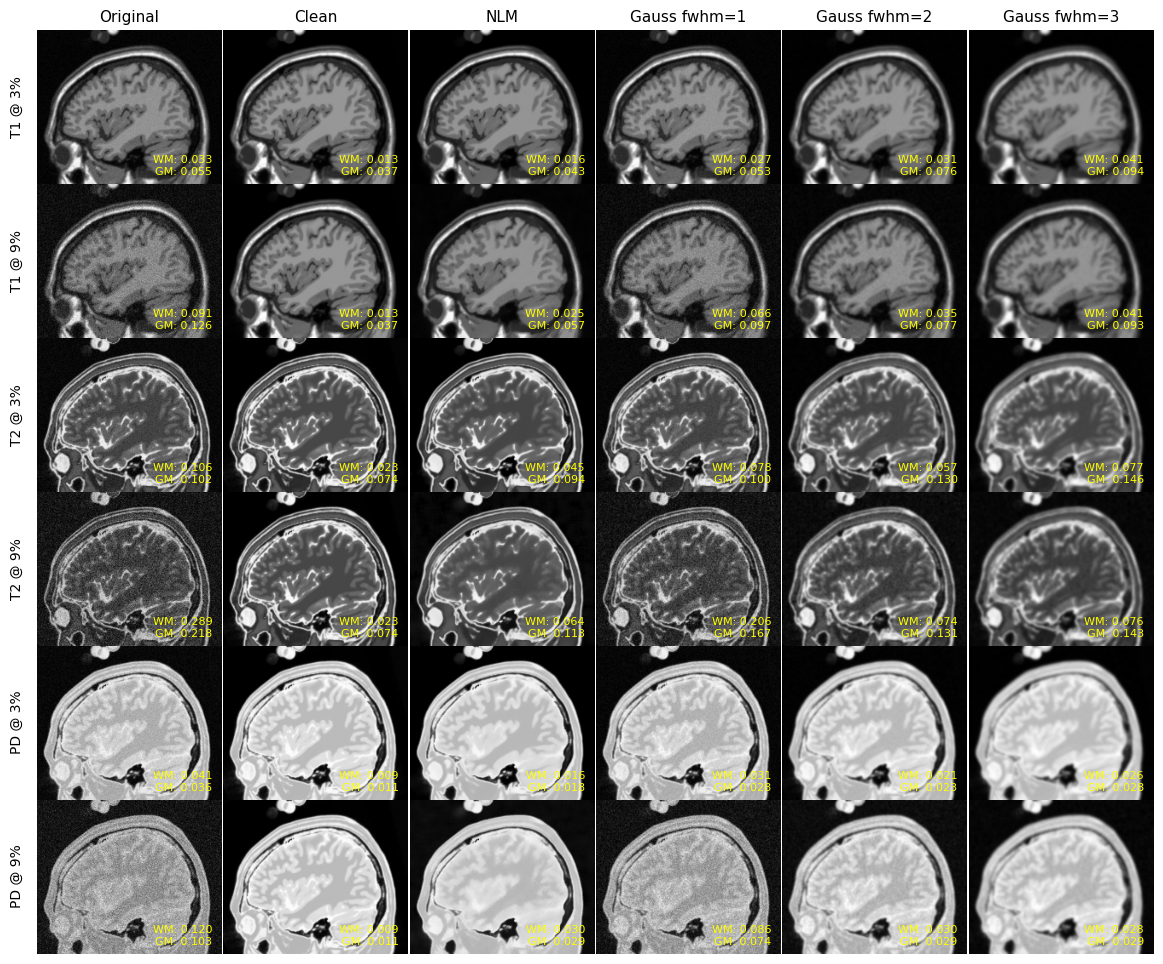

In [194]:
import matplotlib.pyplot as plt
import numpy as np

slice_idx = 50   # Choose one slice index to display consistently

nrows = len(modalities) * len(noise_levels)
ncols = len(methods)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 12), squeeze=False)

for i, modality in enumerate(modalities):
    for j, noise in enumerate(noise_levels):
        row_idx = i * len(noise_levels) + j
        for k, method in enumerate(methods):
            ax = axes[row_idx, k]

            entry = results.get((modality, noise, method))
            if entry is not None:
                img = entry["image"]
                slice_img = np.rot90(img.get_fdata()[:, :, slice_idx], k=1)
                ax.imshow(slice_img.T, cmap="gray", origin="lower")
                ax.axis("off")

                wm_cov = entry["cov_wm"]
                gm_cov = entry["cov_gm"]
                ax.text(
                    0.95, 0.05,
                    f"WM: {wm_cov:.3f}\nGM: {gm_cov:.3f}",
                    color="yellow", fontsize=8,
                    ha="right", va="bottom",
                    transform=ax.transAxes
                )

# Column headers
for k, method in enumerate(methods):
    axes[0, k].set_title(method, fontsize=11)

# ----- Row labels in the left margin -----
row_labels = [f"{m} @ {n}" for m in modalities for n in noise_levels]

# Leave room on the left and tighten spacing
fig.subplots_adjust(left=0.04, wspace=0, hspace=0)

# Place one label centered alongside each row
for r, label in enumerate(row_labels):
    y = 0.88 - (r + 0.5) / (nrows+1.8)  # figure coords: 1 at top, 0 at bottom
    fig.text(0.02, y, label, va='center', ha='left', fontsize=10, rotation='vertical')

plt.show()
fig.savefig("grid_output.png", dpi=500, bbox_inches="tight", pad_inches=0.05)


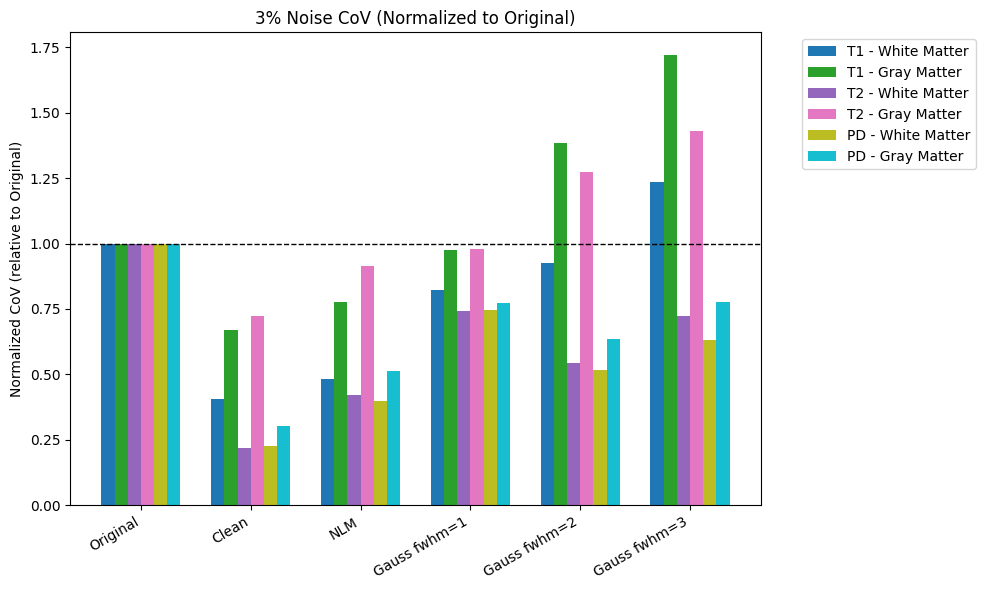

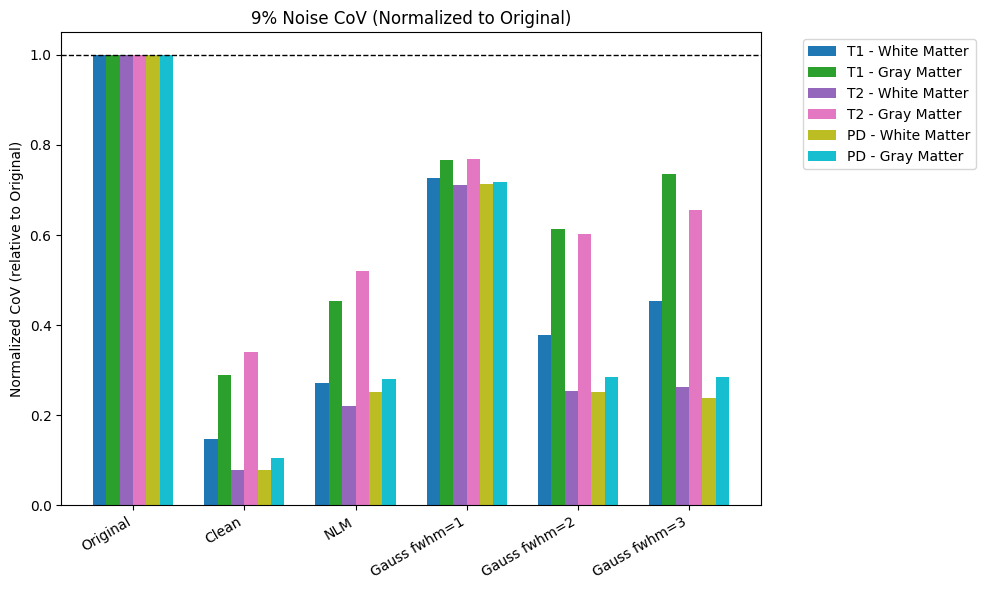

In [195]:
import matplotlib.pyplot as plt
import numpy as np

rows = [
    ("T1", "cov_wm"),
    ("T1", "cov_gm"),
    ("T2", "cov_wm"),
    ("T2", "cov_gm"),
    ("PD", "cov_wm"),
    ("PD", "cov_gm")
]

colors = plt.cm.tab10(np.linspace(0, 1, len(rows)))

def plot_cov(noise, title):
    x = np.arange(len(methods))
    bar_width = 0.12
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (modality, metric_key) in enumerate(rows):
        # Get the baseline "Original" CoV
        baseline = results[(modality, noise, "Original")][metric_key]
        mask_name = "White Matter" if metric_key == "cov_wm" else "Gray Matter"

        # Compute normalized values
        values = []
        for method in methods:
            entry = results.get((modality, noise, method))
            if entry is not None:
                values.append(entry[metric_key] / baseline)
            else:
                values.append(np.nan)

        # Offset the bars so they group nicely
        offset = (i - len(rows)/2) * bar_width + bar_width/2
        ax.bar(x + offset, values, bar_width,
               label=f"{modality} - {mask_name}", color=colors[i])

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=30, ha="right")
    ax.set_ylabel("Normalized CoV (relative to Original)")
    ax.set_title(title)
    ax.axhline(1.0, color="black", linestyle="--", linewidth=1)  # baseline line
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Plot WM ---
plot_cov('3%', "3% Noise CoV (Normalized to Original)")

# --- Plot GM ---
plot_cov('9%', "9% Noise CoV (Normalized to Original)")


In [196]:
import numpy as np

def _match_noise_value(noise_levels, targets=("3%", "9%")):
    """Return a dict mapping pretty labels '3%'/'9%' to the actual values in noise_levels."""
    def to_pct_str(x):
        if isinstance(x, str):
            return x.strip()
        try:
            return f"{int(round(float(x) * 100))}%"
        except Exception:
            return str(x)

    found = {}
    for nl in noise_levels:
        s = to_pct_str(nl)
        if s in targets:
            found[s] = nl
    return found

def mean_metrics_by_method(results, modalities, methods, noise_value):
    """Return two arrays (wm_means, gm_means) of length len(methods) for a given noise value."""
    wm_means, gm_means = [], []
    for method in methods:
        wm_vals, gm_vals = [], []
        for modality in modalities:
            entry = results.get((modality, noise_value, method))
            if entry is None:
                continue
            if "cov_wm" in entry:
                wm_vals.append(entry["cov_wm"])
            if "cov_gm" in entry:
                gm_vals.append(entry["cov_gm"])
        wm_means.append(np.mean(wm_vals) if wm_vals else np.nan)
        gm_means.append(np.mean(gm_vals) if gm_vals else np.nan)
    return np.array(wm_means), np.array(gm_means)

# --- Compute 6 values per noise level ---
targets = _match_noise_value(noise_levels, targets=("3%", "9%"))

for label in ("3%", "9%"):
    if label not in targets:
        print(f"Warning: couldn't find {label} in noise_levels; skipping.")
        continue
    noise_val = targets[label]
    wm_avg, gm_avg = mean_metrics_by_method(results, modalities, methods, noise_val)

    print(f"\n{label} — WM cov means per method (len={len(wm_avg)}):")
    for m, v in zip(methods, wm_avg):
        print(f"  {m}: {v:.4f}" if np.isfinite(v) else f"  {m}: NaN")

    print(f"{label} — GM cov means per method (len={len(gm_avg)}):")
    for m, v in zip(methods, gm_avg):
        print(f"  {m}: {v:.4f}" if np.isfinite(v) else f"  {m}: NaN")

    # If you only need one number per bar, pick one (e.g., WM) or average both:
    combined = np.nanmean(np.vstack([wm_avg, gm_avg]), axis=0)
    print(f"{label} — Combined (WM+GM) means per method:")
    for m, v in zip(methods, combined):
        print(f"  {m}: {v:.4f}" if np.isfinite(v) else f"  {m}: NaN")



3% — WM cov means per method (len=6):
  Original: 0.0600
  Clean: 0.0153
  NLM: 0.0257
  Gauss fwhm=1: 0.0455
  Gauss fwhm=2: 0.0365
  Gauss fwhm=3: 0.0478
3% — GM cov means per method (len=6):
  Original: 0.0643
  Clean: 0.0405
  NLM: 0.0515
  Gauss fwhm=1: 0.0604
  Gauss fwhm=2: 0.0762
  Gauss fwhm=3: 0.0894
3% — Combined (WM+GM) means per method:
  Original: 0.0622
  Clean: 0.0279
  NLM: 0.0386
  Gauss fwhm=1: 0.0529
  Gauss fwhm=2: 0.0564
  Gauss fwhm=3: 0.0686

9% — WM cov means per method (len=6):
  Original: 0.1668
  Clean: 0.0153
  NLM: 0.0396
  Gauss fwhm=1: 0.1193
  Gauss fwhm=2: 0.0461
  Gauss fwhm=3: 0.0487
9% — GM cov means per method (len=6):
  Original: 0.1489
  Clean: 0.0405
  NLM: 0.0664
  Gauss fwhm=1: 0.1126
  Gauss fwhm=2: 0.0792
  Gauss fwhm=3: 0.0883
9% — Combined (WM+GM) means per method:
  Original: 0.1578
  Clean: 0.0279
  NLM: 0.0530
  Gauss fwhm=1: 0.1159
  Gauss fwhm=2: 0.0627
  Gauss fwhm=3: 0.0685
